<a href="https://colab.research.google.com/github/fbeilstein/simplest_smo_ever/blob/master/simple_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

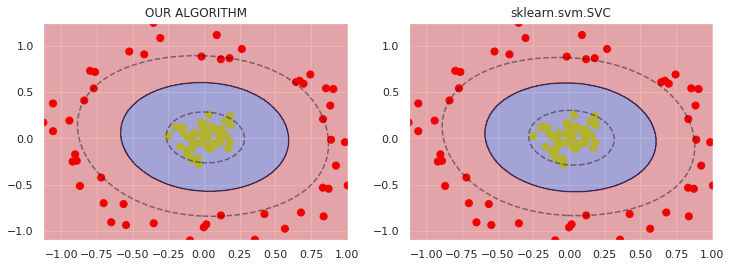

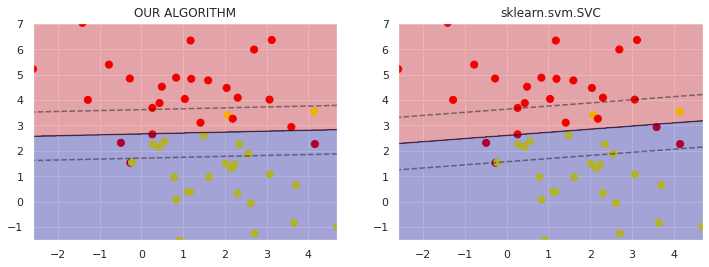

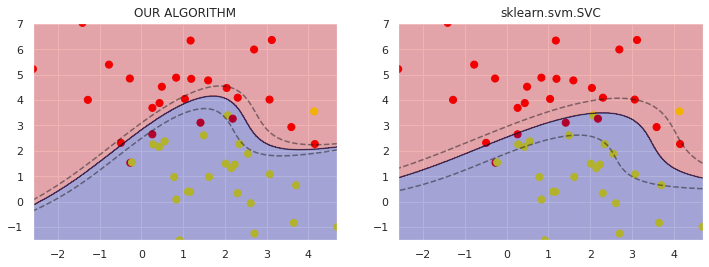

In [17]:
import numpy as np

class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                   'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2

######### TESTS ############
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)

X, y = make_circles(100, factor=.1, noise=.1)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='rbf', C=10, max_iter=60, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')

X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=1.4)
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='linear', C=10, max_iter=60), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='poly', C=5, max_iter=60, degree=3), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='poly', C=5, degree=3), axs[1], 'sklearn.svm.SVC')

sklearn:


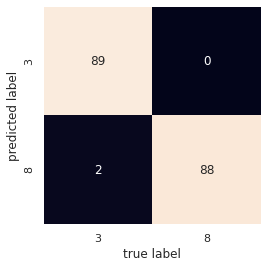

custom svm:


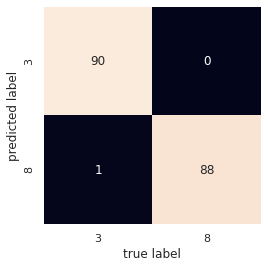

In [16]:
###### TESTS WITH MNIST ###########

from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_A = 3
class_B = 8

digits = datasets.load_digits()
mask = (digits.target == class_A) | (digits.target == class_B)
data = digits.images.reshape((len(digits.images), -1))[mask]
target = digits.target[mask] // max([class_A, class_B]) # rescale to 0,1
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=True)

def plot_confusion(clf):
  clf.fit(X_train, y_train)
  y_fit = clf.predict(X_test)

  mat = confusion_matrix(y_test, y_fit)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=[class_A,class_B], yticklabels=[class_A,class_B])
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

print('sklearn:')
plot_confusion(svm.SVC(C=1.0, kernel='rbf', gamma=0.001))
print('custom svm:')
plot_confusion(SVM(kernel='rbf', C=1.0, max_iter=60, gamma=0.001))